In [33]:
import os

import pandas as pd
import numpy as np

import requests

#! pip install geocoder
import geocoder # import geocoder

#! pip install folium
import folium

from IPython.display import display

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#! pip install seaborn
import seaborn as sns

from sklearn.cluster import KMeans

%matplotlib inline

<h1><center>The Battle of Neighborhoods! </center></h1>

The Battle of Neighborhoods ('The Battle' for short) looks at Toronto's neighborhoods in order to *cluster* them into groups *based on* criteria related to *attractiveness of living and opportunities for entertainment* (venues). It takes advantage of *two* sources of information: 
 1. https://torontolife.com/neighbourhood-rankings/# 
 2. https://foursquare.com/ 
 
The first source is especially useful with its list of Toronto's Neighborhoods, their latitude and longitude and ranking based on 10 criteria: housing, safety, transit, shopping, health, entertainment, community, diversity, education and employment. For each criteria the neighborhoods get a ranking form 0 to 100. Interestingly enough, you may notice that the names of the neighborhoods differ from other sources of information to another. This is due to the fact that different data sources might group together some neighborhoods, or split others into different areas, or even use old-fashioned names, which hinders comparability. Therefore, it is better when all data: neighborhoods and their latitude and longitude, come from the same source of information, as is here the case.  
'The Battle' uses *K-means Clustering*. Hence, another point worth consideration is that K-means clustering uses some distance metric, for example Euclidean distance, which means that K-means algorithm isn't directly applicable for categorical variables because Euclidean distance function isn't really meaningful for discrete variables. 
All relevant data from the website of Toronto Life is continuous, moreover, the ranking for each category lies between 0 and 100, which implies that we do not need to rescale or normalize the data.   
The data have been scraped using Selenium in the script in torontolife_scraper.ipynb on this repo: <a href="https://github.com/mittpy/Coursera_Capstone" >Link to Repo</a>. Selenium is convenient when using dynamic web elements, which contents change as JavaScript executes, as is the case with changing ratings.  
  
The second source of information, Foursquare website, could be used for exploring venues and clustering neighborhoods based on their entertainment profile. Foursquare API will be used used to explore each neighborhood and return maximum 200 venues within radius of 1 000 meters of its the longitude and latitude. Again, as mentioned earlier, K-means clustering uses some distance metric, for example Euclidean distance, which means that it isn't directly applicable for categorical variables. Hence, venues categories will be converted to dummy variables with value of 1 if such venue is present in the neighborhood and 0 otherwise. 

### Tagret stakeholders 

The projects targets people who want to weight the relative advantages of living in a particular area of Toronto. These could be future students looking for the most dynamic areas, or areas with better education. These could be people planning to move there or to send their children to learn, who might be interested in levels of education, safety, employment, etc. in the neighborhood.   

Let's not forget that __Toronto is among the 5 biggest North American cities__.

### Project logical sections

'The Battle' has two distinct sections. The first is the clastering of the neighborhoods based on attractivness of living. The second is the clustering based on entertainment profile. 

### Obtain the data from the first source

The, first step is to scrape https://torontolife.com/neighbourhood-rankings/# for Toronto's Neighborhoods, their latitude and longitude and ranking based on 10 criteria: housing, safety, transit, shopping, health, entertainment, community, diversity, education and employment. This is done using Selenium in the script in torontolife_scraper.ipynb on this repo: Link to Repo. Selenium is convinient when using dynamic web elements, which contents change as JavaScript executes, as is the case with changing ratings.

Here, we only read the resulting csv file. Which can be found in the data folder of the same repo: <a href="https://github.com/mittpy/Coursera_Capstone">Link to Repo</a> .

In [2]:
ranked_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'torontolife_rankings.csv'), index_col=0)
ranked_df.head()

Neighborhood  Housing  Safety  Transit  Shopping  Health  \
0  Runnymede-Bloor West Village     97.1    95.0     74.3      87.9    88.6   
1               North Riverdale     90.0    49.3     86.4      82.9    98.6   
2           Mount Pleasant East     92.1    98.6     72.9      61.4   100.0   
3                      Danforth     78.6    62.9     89.3      87.9    87.1   
4           Lawrence Park North     83.6    87.1     81.4      37.1    97.9   

   Entertainment  Community  Diversity  Education  Employment   Latitude  \
0           72.9       77.9        8.6       73.6       100.0  43.651100   
1           86.4       80.7       10.7       87.1        96.4  43.675291   
2           72.1       48.6        9.3       68.6        95.7  43.710320   
3           93.6       72.1       13.6       62.1        81.4  43.681597   
4           75.0       76.4        3.6       70.7        99.3  43.729182   

   Longitude  
0 -79.476583  
1 -79.348588  
2 -79.390914  
3 -79.331690  
4 -79.403409

### Explore the data from the first source

Let's first quickly visualize the neighborhoods ot Toronto Map

In [3]:
lat_toronto = 43.653908
lng_toronto = -79.384293

toronto_map = folium.Map(location = [lat_toronto, lng_toronto], zoom_start = 10)

for lat, lng, neighborhood in zip(ranked_df.Latitude, ranked_df.Longitude, ranked_df.Neighborhood):

    label = '{}'.format(neighborhood)
    label = folium.Popup(neighborhood, parse_html = False)
    folium.CircleMarker(location = [lat, lng], radius = 5, popup = label, color = 'red', 
                        fill = True, fill_color = 'pink', fill_opacity = 0.9).add_to(toronto_map)

toronto_map.save('data/toronto_map.html')
toronto_map

As next, we could plot on a bar graph the ranking of the Neighborhoods, as:
 1. A, calculate the average ranking by placing equal importance on each of the 10 criteria: housing, safety, transit, shopping, health, entertainment, community, diversity, education and employment;
 2. B, plot only safety, education, employment and health for those that are on the more safety side;
 3. C, plot only housing, shopping, community and entertainment for those that are on the entertaining side;
 4. D, experiment by placing different relative importance on the criterias.

A, plot the average ranking for the top 10 neighborhoods by placing equal importance on each of the 10 criteria: housing, safety, transit, shopping, health, entertainment, community, diversity, education and employment

In [4]:
ranked_df['Avg Ranking'] = round(ranked_df.mean(axis = 1), 2)
ranked_df.head(3)

Neighborhood  Housing  Safety  Transit  Shopping  Health  \
0  Runnymede-Bloor West Village     97.1    95.0     74.3      87.9    88.6   
1               North Riverdale     90.0    49.3     86.4      82.9    98.6   
2           Mount Pleasant East     92.1    98.6     72.9      61.4   100.0   

   Entertainment  Community  Diversity  Education  Employment   Latitude  \
0           72.9       77.9        8.6       73.6       100.0  43.651100   
1           86.4       80.7       10.7       87.1        96.4  43.675291   
2           72.1       48.6        9.3       68.6        95.7  43.710320   

   Longitude  Avg Ranking  
0 -79.476583        61.67  
1 -79.348588        61.07  
2 -79.390914        56.97

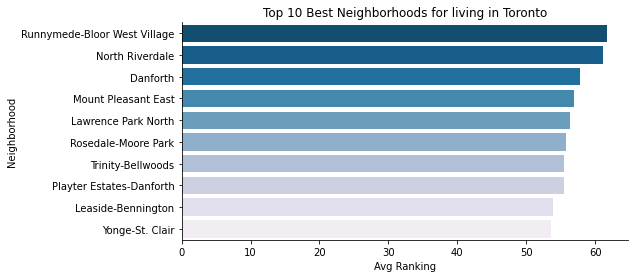

In [5]:
plt.figure(figsize=(8, 4))

sns.barplot(x = 'Avg Ranking', y = "Neighborhood", data = ranked_df.sort_values('Avg Ranking', ascending= False)[:10], 
            orient = 'h', palette = 'PuBu_r')
sns.despine(top=True, right=True)

plt.title('Top 10 Best Neighborhoods for living in Toronto')
plt.savefig('data/barplot_1', bbox_inches='tight')
plt.show()

B, let's plot only safety, education, employment and health for the top 5 neighborhoods based on average ranking.

In [6]:
sorted_df = ranked_df.sort_values('Avg Ranking', ascending = False)

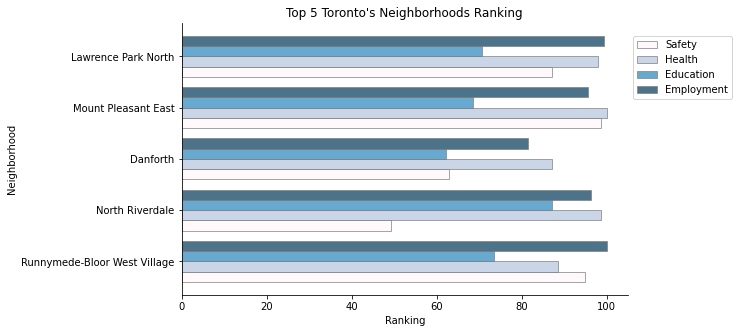

In [7]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
sorted_df[['Safety', 'Health', 'Education', 'Employment', 'Neighborhood']][:5].plot(kind = 'barh', x = 'Neighborhood', 
                                                                                    ax=ax, figsize=(8,5), 
                                                                                    colormap = 'PuBu', width = 0.8, 
                                                                                    edgecolor = 'Gray', alpha = 0.7)
sns.despine()
ax.set_xlabel('Ranking')
legend = ax.legend(bbox_to_anchor=(1.00, 0.97))
ax.set_title('Top 5 Toronto\'s Neighborhoods Ranking')

plt.savefig('data/barplot_2.png', ext='png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

As evident from the graph, the top 5 Toronto's neighborhoods seem to have high ranking and close scores based on employment and health, but differ in safety and education. Yet, it would be interesting to see whether neighborhoods with namely high employment and health rankings are clustered together.  

C, let's plot only housing, shopping, community and entertainment for the top 5 neigborhoods based on average ranking.

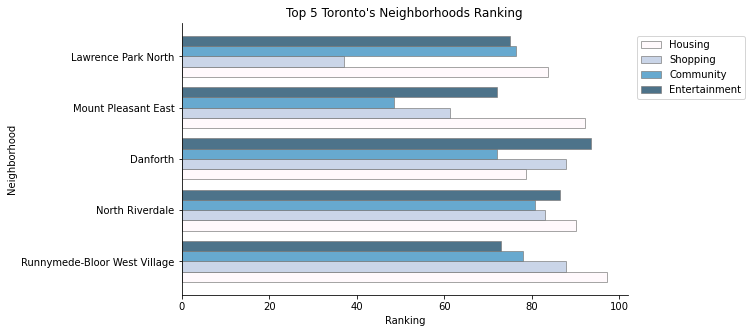

In [8]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
sorted_df[['Housing', 'Shopping', 'Community', 'Entertainment', 'Neighborhood']][:5].plot(kind = 'barh', x = 'Neighborhood', 
                                                                                      ax = ax, figsize=(8,5), 
                                                                                      colormap = 'PuBu', width = 0.8, 
                                                                                      edgecolor = 'Gray', alpha = 0.7)
sns.despine()
ax.set_xlabel('Ranking')
legend = ax.legend(bbox_to_anchor=(1.01, 0.97))
ax.set_title('Top 5 Toronto\'s Neighborhoods Ranking')

plt.savefig('data/barplot_3.png', ext = 'png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

Among the 4 criteria housing and entertainment seem to have high relevance for the ranking of top 5 Toronto Neighborhoods based on avg ranking.

### Apply the K-Means algorithm to the first part of the data

K-means algorithm relies on the correct choice of number of clusters, k. Therefore, the clustering is run across different values of k.   
However, increasing the number of clusters will always reduce the distance of centroids to data points. It is namely the squared  
distance between each point and its centroid that we are trying to minimize, i. e. to minimize the within cluster sum of squared errors.   
This means that increasing k will always decrease the error. Hence, K is determined as the elbow point on the elbow graph,  
where the rate of decrease in the error sharply shifts.  

In [9]:
ranked_df.columns

Index(['Neighborhood', 'Housing', 'Safety', 'Transit', 'Shopping', 'Health',
       'Entertainment', 'Community', 'Diversity', 'Education', 'Employment',
       'Latitude', 'Longitude', 'Avg Ranking'],
      dtype='object')

In [10]:
# set number of clusters
X = ranked_df[['Housing', 'Safety', 'Transit', 'Shopping', 'Health', 'Entertainment', 'Community', 'Diversity', 'Education', 'Employment']]

sum_of_squared_distances = []
Ks = range(1, 26) 

for k in Ks:
    kmc = KMeans(n_clusters = k)
    kmc = kmc.fit(X)
    sum_of_squared_distances.append(kmc.inertia_)

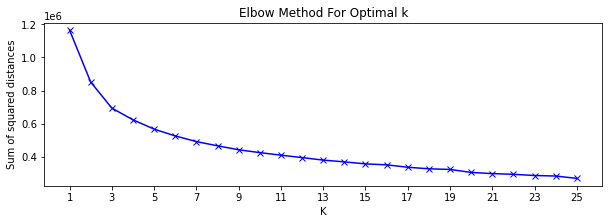

In [11]:
# plot each k and its error, i. e. sum of squared distanced of data points to their nearest cluster centroid.
plt.figure(figsize=(10,3))
plt.plot(Ks, sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.xticks(ticks = range(1, 26, 2))
plt.title('Elbow Method For Optimal k')

plt.savefig('data/opt_K_Attractiveness_of_Living_Clustering.png')
plt.show()

It seams that the point where the rate of decrease in the error shifts in at K=3. After that the shift in the error slows. 

In [12]:
k_opt = 3
kmc = KMeans(n_clusters=k_opt).fit(X)
kmc.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2,
       2, 2, 0, 2, 0, 1, 1, 2, 0, 0, 0, 2, 1, 1, 0, 1, 0, 2, 2, 2, 0, 2,
       1, 2, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
# Add the labels to the dataframe 
ranked_df['Cluster Label'] = kmc.labels_
ranked_df.head(3)

Neighborhood  Housing  Safety  Transit  Shopping  Health  \
0  Runnymede-Bloor West Village     97.1    95.0     74.3      87.9    88.6   
1               North Riverdale     90.0    49.3     86.4      82.9    98.6   
2           Mount Pleasant East     92.1    98.6     72.9      61.4   100.0   

   Entertainment  Community  Diversity  Education  Employment   Latitude  \
0           72.9       77.9        8.6       73.6       100.0  43.651100   
1           86.4       80.7       10.7       87.1        96.4  43.675291   
2           72.1       48.6        9.3       68.6        95.7  43.710320   

   Longitude  Avg Ranking  Cluster Label  
0 -79.476583        61.67              0  
1 -79.348588        61.07              0  
2 -79.390914        56.97              0

Let's explore each cluster. Let's check how many neighborhoods fall into in. 

In [14]:
ranked_df['Cluster Label'].value_counts()

1    67
0    46
2    27
Name: Cluster Label, dtype: int64

In [15]:
print("The largest cluster of the %d includes %d neighborhoods. The second includes %d neighborhoods and the last one has %d." \
     % (k_opt, ranked_df['Cluster Label'].value_counts()[0], ranked_df['Cluster Label'].value_counts()[1], ranked_df['Cluster Label'].value_counts()[2]))

The largest cluster of the 3 includes 46 neighborhoods. The second includes 67 neighborhoods and the last one has 27.


Explore the clusters, the neighborhoods included and compare the average values of the features for each cluster.

In [16]:
ranked_df1 = ranked_df[['Neighborhood' , 'Housing', 'Safety', 'Transit', 'Shopping', 'Health', 'Entertainment', 'Community', 'Diversity', 'Education', 'Employment', 'Avg Ranking','Cluster Label']]

In [17]:
ranked_df1[ranked_df1['Cluster Label'] == 0].reset_index(drop=True)[:5]

Neighborhood  Housing  Safety  Transit  Shopping  Health  \
0  Runnymede-Bloor West Village     97.1    95.0     74.3      87.9    88.6   
1               North Riverdale     90.0    49.3     86.4      82.9    98.6   
2           Mount Pleasant East     92.1    98.6     72.9      61.4   100.0   
3                      Danforth     78.6    62.9     89.3      87.9    87.1   
4           Lawrence Park North     83.6    87.1     81.4      37.1    97.9   

   Entertainment  Community  Diversity  Education  Employment  Avg Ranking  \
0           72.9       77.9        8.6       73.6       100.0        61.67   
1           86.4       80.7       10.7       87.1        96.4        61.07   
2           72.1       48.6        9.3       68.6        95.7        56.97   
3           93.6       72.1       13.6       62.1        81.4        57.75   
4           75.0       76.4        3.6       70.7        99.3        56.37   

   Cluster Label  
0              0  
1              0  
2              0  
3              0  
4              0

In [18]:
summary_df = pd.DataFrame()
summary_df["Cluster '0' Means"] = ranked_df1[ranked_df1['Cluster Label'] == 0].mean(axis = 0)
summary_df.head()

Cluster '0' Means
Housing           55.154348
Safety            46.493478
Transit           80.747826
Shopping          74.165217
Health            69.665217

In [19]:
ranked_df1[ranked_df1['Cluster Label'] == 1].reset_index(drop=True)[:5]

Neighborhood  Housing  Safety  Transit  Shopping  Health  \
0                   Regent Park     20.7    77.1     71.4      76.4    14.3   
1  Agincourt South-Malvern West     35.7    29.3     44.3      60.0    81.4   
2             Hillcrest Village     41.4    60.0     15.7      42.1    67.1   
3                      Milliken     32.9    31.4     31.4      70.7    80.7   
4          Briar Hill-Belgravia     55.7    64.3     54.3      87.1    12.9   

   Entertainment  Community  Diversity  Education  Employment  Avg Ranking  \
0           82.1       82.9       61.4       21.4        25.7        41.47   
1           62.9       39.3       97.9       80.0        29.3        43.72   
2           47.9       42.9       95.7       97.9        41.4        43.05   
3           66.4       68.6      100.0       42.9        15.7        42.10   
4           77.9        2.1       75.7        6.4        42.9        36.96   

   Cluster Label  
0              1  
1              1  
2              1  
3              1  
4              1

In [20]:
summary_df["Cluster '1' Means"] = ranked_df1[ranked_df1['Cluster Label'] == 1].mean(axis=0)

In [21]:
ranked_df1[ranked_df1['Cluster Label'] == 2].reset_index(drop=True).head()

Neighborhood  Housing  Safety  Transit  Shopping  Health  \
0  Leaside-Bennington    100.0    84.3     59.3      34.3    82.9   
1  Danforth-East York     85.7    80.7     60.0      72.9    63.6   
2      Kingsway South     99.3    89.3     60.7      13.6    80.0   
3       Old East York     80.7    85.0     50.0      38.6    38.6   
4   High Park-Swansea     94.3    40.0     67.1      27.9    96.4   

   Entertainment  Community  Diversity  Education  Employment  Avg Ranking  \
0           40.7       98.6        2.1       84.3        95.0        53.82   
1           50.0       95.7       27.9       16.4        72.1        49.11   
2           37.9      100.0        2.9       40.0        84.3        47.68   
3           70.0       93.6       23.6       43.6        82.1        47.51   
4           48.6       77.9       16.4       32.1        97.1        46.83   

   Cluster Label  
0              2  
1              2  
2              2  
3              2  
4              2

In [22]:
summary_df["Cluster '2' Means"] = ranked_df1[ranked_df1['Cluster Label'] == 2].mean(axis = 0)

In [23]:
summary_df.drop('Cluster Label', axis = 0, inplace = True)

In [24]:
summary_df

Cluster '0' Means  Cluster '1' Means  Cluster '2' Means
Housing                55.154348          32.865672          85.055556
Safety                 46.493478          44.250746          71.666667
Transit                80.747826          36.447761          32.722222
Shopping               74.165217          45.614925          20.740741
Health                 69.665217          35.467164          53.855556
Entertainment          79.486957          40.743284          24.559259
Community              38.243478          45.785075          81.325926
Diversity              28.384783          72.950746          31.381481
Education              64.854348          40.005970          50.566667
Employment             73.960870          26.298507          69.459259
Avg Ranking            47.952609          32.064328          40.468889

In [25]:
summary_df.sort_values(["Cluster '2' Means", "Cluster '1' Means", "Cluster '0' Means"], ascending = True, inplace = True)

In [26]:
summary_df

Cluster '0' Means  Cluster '1' Means  Cluster '2' Means
Shopping               74.165217          45.614925          20.740741
Entertainment          79.486957          40.743284          24.559259
Diversity              28.384783          72.950746          31.381481
Transit                80.747826          36.447761          32.722222
Avg Ranking            47.952609          32.064328          40.468889
Education              64.854348          40.005970          50.566667
Health                 69.665217          35.467164          53.855556
Employment             73.960870          26.298507          69.459259
Safety                 46.493478          44.250746          71.666667
Community              38.243478          45.785075          81.325926
Housing                55.154348          32.865672          85.055556

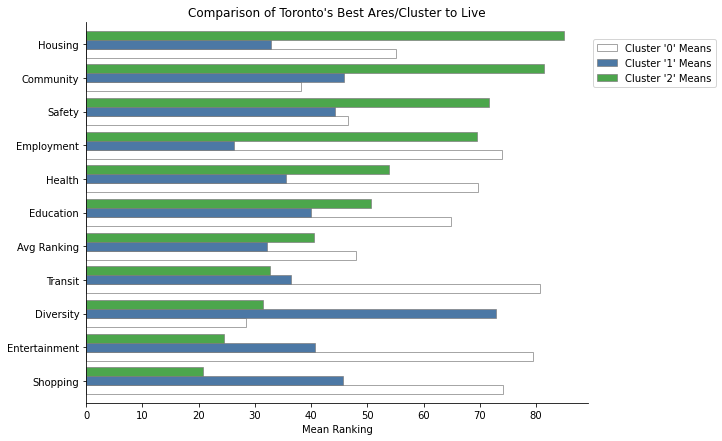

In [27]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
summary_df.plot(kind='barh', ax = ax, figsize=(9,7), colormap = 'ocean_r', width = 0.8, edgecolor = 'Gray', alpha = 0.7)

sns.despine()
ax.set_xlabel('Mean Ranking')
legend = ax.legend(bbox_to_anchor=(1.00, 0.97))
ax.set_title('Comparison of Toronto\'s Best Ares/Cluster to Live')

plt.savefig('data/barplot_4.png', ext='png', bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

This visualization facilitates the comparison between the three cluster.  
  
The __third cluster__, which if you recall contains 46 neighborhoods and is the second largest cluster in terms of number of neighborhoods, has __highest average ranking__ and __highest employment__, __education__, __entertainment__, __health__, __shopping__ and __transit__, meaning that the second largest cluster (based on number of neighborhoods) is the leader in 6 of 10 ranking criteria.  
  
The __second cluster__ has only 27 neighborhoods and is the smallest of the three (based on number of neighborhoods). It has the last but one average ranking and highest average scores for __community__, __safety__, __housing__.  
  
The __first cluster__ is the largest one (based on number of neighborhoods). It includes 67, almost half of the 140 neighborhoods and yet it is __the worst graded__. It is __the leader in terms of diversity__. Diversity is seen as the percentage of visible minorities, people whose mother tongues are not French or English, and first- and second-generation immigrants. It also has __the worst average results for__ __education__, __employment__, __health__, __safety__ and __housing__.
The fact that almost half of the neighborhoods fall there means that Toronto is a really diverse city, but its diversity is not what makes it attractive for living. Obviously, as the highest average ranking implies, __what makes an area attractive for living is employment, education, entertainment, health, shopping and transit__.  
  
So, all in all, it could be concluded that Toronto's neighborhoods are clustered into three groups. The first and most numerous is most diverse, where people from different countries live together, but it has worst conditions for education, work, healthcare, worst housing and safety.  
On the other hand, the best ranked neighborhoods provide best conditions for education, work, healthcare, entertainment, shopping, traveling.   
And there is the smallest cluster (based on number of neighborhoods), with highest safety, housing and community scores.

#### Obviously, it would be interesting to see the average age of the population in the clusters, as the smallest (based on number of neighborhoods) is the safest one, with best community and housing performances. And there is the average-sized cluster with best opportunities for education, work, entertainment, healthcare, traveling.  
Whatever we say about the age profile of the clusters would be a speculation, but you can still take a guess.

#### Let's visualize the clusters:

In [28]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lng_toronto], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k_opt)
ys = [i + x + (i*x)**2 for i in range(k_opt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ranked_df['Latitude'], ranked_df['Longitude'],
                                  ranked_df['Neighborhood'], ranked_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save('data/attractiveness_of_living.html')
map_clusters

## Second part of the analysis  
Here Toronto's Neighborhoods are clustered based their entertainment oportinuties. The information about the nearby venues is obtained vie Forsquare API.

In [29]:
venues_df_1 = ranked_df[["Neighborhood", "Latitude", "Longitude", 'Avg Ranking']]
venues_df_1.head()

Neighborhood   Latitude  Longitude  Avg Ranking
0  Runnymede-Bloor West Village  43.651100 -79.476583        61.67
1               North Riverdale  43.675291 -79.348588        61.07
2           Mount Pleasant East  43.710320 -79.390914        56.97
3                      Danforth  43.681597 -79.331690        57.75
4           Lawrence Park North  43.729182 -79.403409        56.37

In [30]:
# Foursquare Credentials
CLIENT_ID = 'PY1CS2HDSFYG05EEGYLLTW0FNAVVABZLW3LNSEHENGCQOKG2' # your Foursquare ID
CLIENT_SECRET = 'O35UDS3VRE0L1CSGACLLNVVP3FNIMNSMBPBKOZQAQWWFMWCD' # your Foursquare Secret
VERSION = '20203004' # Foursquare API version

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
toronto_venues = getNearbyVenues(names=venues_df_1['Neighborhood'],
                                   latitudes=venues_df_1['Latitude'],
                                   longitudes=venues_df_1['Longitude']
                                  )

Runnymede-Bloor West Village
North Riverdale
Mount Pleasant East
Danforth
Lawrence Park North
Rosedale-Moore Park
Playter Estates-Danforth
Trinity-Bellwoods
Leaside-Bennington
Yonge-St. Clair
The Beaches
Palmerston-Little Italy
Bedford Park-Nortown
Cabbagetown-South St. James Town
Mount Pleasant West
Danforth-East York
Yonge-Eglinton
Kingsway South
Wychwood
Bay Street Corridor
University
Old East York
High Park North
Annex
Casa Loma
East End-Danforth
High Park-Swansea
Corso Italia-Davenport
Moss Park
Yorkdale-Glen Park
Lawrence Park South
Church-Yonge Corridor
Junction Area
Little Portugal
Waterfront Communities-The Island
Blake-Jones
Greenwood-Coxwell
Bridle Path-Sunnybrook-York Mills
Roncesvalles
Kensington-Chinatown
Stonegate-Queensway
Forest Hill North
Woodbine Corridor
Forest Hill South
Thistletown-Beaumond Heights
Woodbine-Lumsden
Islington-City Centre West
Markland Wood
Dufferin Grove
Regent Park
Agincourt South-Malvern West
Birchcliffe-Cliffside
North St. James Town
Lansing-Wes

In [81]:
print(toronto_venues.shape)
toronto_venues.head()

(2680, 7)


Neighborhood  Neighborhood Latitude  \
0  Runnymede-Bloor West Village                43.6511   
1  Runnymede-Bloor West Village                43.6511   
2  Runnymede-Bloor West Village                43.6511   
3  Runnymede-Bloor West Village                43.6511   
4  Runnymede-Bloor West Village                43.6511   

   Neighborhood Longitude                          Venue  Venue Latitude  \
0              -79.476583                      DAVIDsTEA       43.650380   
1              -79.476583              Baka Gallery Cafe       43.651040   
2              -79.476583      Bread & Roses Bakery Cafe       43.651194   
3              -79.476583     Zaza Espresso Bar & Gelato       43.651106   
4              -79.476583  Shakey's Original Bar & Grill       43.650771   

   Venue Longitude Venue Category  
0       -79.478819       Tea Room  
1       -79.477605           Café  
2       -79.476657         Bakery  
3       -79.477710           Café  
4       -79.477581      Gastropub

Let's see how many unique venues are there in the dataset.

In [36]:
toronto_venues['Venue'].value_counts()

Tim Hortons                                    59
Starbucks                                      58
Subway                                         38
Shoppers Drug Mart                             37
TD Canada Trust                                27
                                               ..
Queen's Park                                    1
Ki Modern Japanese + Bar                        1
The Ambassador                                  1
GoodLife Fitness Toronto Yonge and St Clair     1
Crepe TO                                        1
Name: Venue, Length: 1941, dtype: int64

In [37]:
print("There are %d unique number of venue names in the dataset of %d venues." \
      %(toronto_venues['Venue'].value_counts().count(), toronto_venues.shape[0]))

There are 1941 unique number of venue names in the dataset of 2680 venues.


In [38]:
print("The 10 most common venues are: ")
toronto_venues['Venue'].value_counts()[:10]

The 10 most common venues are: 


Tim Hortons                  59
Starbucks                    58
Subway                       38
Shoppers Drug Mart           37
TD Canada Trust              27
Pizza Pizza                  19
LCBO                         17
RBC Royal Bank               17
Aroma Espresso Bar           15
Popeyes Louisiana Kitchen    14
Name: Venue, dtype: int64

In [40]:
print("Including the largest Canadian bank 'RBC Royal Bank'.")

Including the largest Canadian bank 'RBC Royal Bank'.


Let's check whether there are overlapping venues based on their location and if, so, then we could change the radius and number of venues to be included when quering data from Forsquare API. 

In [41]:
toronto_venues['Lat Lng'] = [str(lat) + ", " + str(lng) for lat, lng in zip(toronto_venues['Venue Latitude'], 
                                                                            toronto_venues['Venue Longitude'])]
print("There are %d number of unique venue locations out of %d total venues." % (toronto_venues['Lat Lng'].unique().shape[0], 
                                                                        toronto_venues.shape[0]))
toronto_venues.head()

There are 2473 number of unique venue locations out of 2680 total venues.


Neighborhood  Neighborhood Latitude  \
0  Runnymede-Bloor West Village                43.6511   
1  Runnymede-Bloor West Village                43.6511   
2  Runnymede-Bloor West Village                43.6511   
3  Runnymede-Bloor West Village                43.6511   
4  Runnymede-Bloor West Village                43.6511   

   Neighborhood Longitude                          Venue  Venue Latitude  \
0              -79.476583                      DAVIDsTEA       43.650380   
1              -79.476583              Baka Gallery Cafe       43.651040   
2              -79.476583      Bread & Roses Bakery Cafe       43.651194   
3              -79.476583     Zaza Espresso Bar & Gelato       43.651106   
4              -79.476583  Shakey's Original Bar & Grill       43.650771   

   Venue Longitude Venue Category                                 Lat Lng  
0       -79.478819       Tea Room  43.650380014739355, -79.47881908403849  
1       -79.477605           Café   43.65103966439781, -79.47760530158712  
2       -79.476657         Bakery  43.651194318292276, -79.47665677628656  
3       -79.477710           Café    43.65110626640462, -79.4777101044724  
4       -79.477581      Gastropub    43.6507708866875, -79.47758071386558

While there is a large portion of overlapping venues between neighborhoods, we can change the maximum number of venues to get as response from Forsquare API and the radius for each neighborhood. 

When exploring Toronto's neighborhoods venues via Forsquare API within a radius of 1000 meters from the neighborhood location and a limit of maximum 200 venues, there were more than 6000 venues but 1/3 were overlapping among neighborhoods. So, the radius were restricted to 500 meters and the maximum number of venues to 100 and thus, there are 2473 number of unique venue locations out of 2680 total venues.

Let's check how many venues were returned for each neighborhood and see the top 10 'venue-intense' Neighborhoods.

In [42]:
toronto_venues.groupby(by='Neighborhood').count().sort_values('Venue', ascending=False)[:10]

Neighborhood Latitude  \
Neighborhood                                               
Bay Street Corridor                                  100   
Church-Yonge Corridor                                100   
North St. James Town                                  79   
Little Portugal                                       78   
Waterfront Communities-The Island                     76   
Yonge-Eglinton                                        75   
Trinity-Bellwoods                                     68   
North Riverdale                                       67   
Mount Pleasant West                                   66   
Don Valley Village                                    65   

                                   Neighborhood Longitude  Venue  \
Neighborhood                                                       
Bay Street Corridor                                   100    100   
Church-Yonge Corridor                                 100    100   
North St. James Town                                   79     79   
Little Portugal                                        78     78   
Waterfront Communities-The Island                      76     76   
Yonge-Eglinton                                         75     75   
Trinity-Bellwoods                                      68     68   
North Riverdale                                        67     67   
Mount Pleasant West                                    66     66   
Don Valley Village                                     65     65   

                                   Venue Latitude  Venue Longitude  \
Neighborhood                                                         
Bay Street Corridor                           100              100   
Church-Yonge Corridor                         100              100   
North St. James Town                           79               79   
Little Portugal                                78               78   
Waterfront Communities-The Island              76               76   
Yonge-Eglinton                                 75               75   
Trinity-Bellwoods                              68               68   
North Riverdale                                67               67   
Mount Pleasant West                            66               66   
Don Valley Village                             65               65   

                                   Venue Category  Lat Lng  
Neighborhood                                                
Bay Street Corridor                           100      100  
Church-Yonge Corridor                         100      100  
North St. James Town                           79       79  
Little Portugal                                78       78  
Waterfront Communities-The Island              76       76  
Yonge-Eglinton                                 75       75  
Trinity-Bellwoods                              68       68  
North Riverdale                                67       67  
Mount Pleasant West                            66       66  
Don Valley Village                             65       65

Let's find out how many unique categories can be curated from all the returned venues.

In [43]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 299 uniques categories.


### Let's analyzi each neighborhood and apply 'one-hot-encoding' to the venue categories. 
  
The neigborhoods are clustered based on venue category, meaning that the categories will serve as features. K-means algorithm uses some distance metric, for example Euclidean distance, which means that it isn't directly applicable for categorical variables. Hence, venues categories will be converted to dummy variables with value of 1 if such venue is present in the neighborhood and 0 otherwise.

In [44]:
# one hot encoding
onehot_toronto = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot_toronto['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot_toronto.columns[-1]] + list(onehot_toronto.columns[:-1])
onehot_toronto = onehot_toronto[fixed_columns]

print("We get total number of samples (rows): %d and number of features (columns): %d" %(onehot_toronto.shape[0], onehot_toronto.shape[1]))
onehot_toronto.head()

We get total number of samples (rows): 2680 and number of features (columns): 299


Yoga Studio  Accessories Store  Afghan Restaurant  African Restaurant  \
0            0                  0                  0                   0   
1            0                  0                  0                   0   
2            0                  0                  0                   0   
3            0                  0                  0                   0   
4            0                  0                  0                   0   

   American Restaurant  Animal Shelter  Antique Shop  Aquarium  \
0                    0               0             0         0   
1                    0               0             0         0   
2                    0               0             0         0   
3                    0               0             0         0   
4                    0               0             0         0   

   Argentinian Restaurant  Art Gallery  ...  University  \
0                       0            0  ...           0   
1                       0            0  ...           0   
2                       0            0  ...           0   
3                       0            0  ...           0   
4                       0            0  ...           0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                              0                 0            0   
1                              0                 0            0   
2                              0                 0            0   
3                              0                 0            0   
4                              0                 0            0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Wings Joint  \
0                      0                0         0          0            0   
1                      0                0         0          0            0   
2                      0                0         0          0            0   
3                      0                0         0          0            0   
4                      0                0         0          0            0   

   Women's Store  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 299 columns]

Next, the rows are grouped by neighborhood and by taking the mean of the frequency of occurrence of each category¶

In [45]:
grouped = onehot_toronto.groupby('Neighborhood', as_index = False).mean()
print("There are %d neighborhoods and %d unique venue categories." %(grouped.shape[0], grouped.shape[1]))
grouped.head(2)

There are 140 neighborhoods and 299 unique venue categories.


Neighborhood  Yoga Studio  Accessories Store  \
0               Agincourt North          0.0                0.0   
1  Agincourt South-Malvern West          0.0                0.0   

   Afghan Restaurant  African Restaurant  American Restaurant  Animal Shelter  \
0                0.0                 0.0                  0.0             0.0   
1                0.0                 0.0                  0.0             0.0   

   Antique Shop  Aquarium  Argentinian Restaurant  ...  University  \
0           0.0       0.0                     0.0  ...         0.0   
1           0.0       0.0                     0.0  ...         0.0   

   Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0                            0.0              0.00          0.0   
1                            0.0              0.04          0.0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Wings Joint  \
0               0.033333              0.0       0.0        0.0     0.033333   
1               0.040000              0.0       0.0        0.0     0.000000   

   Women's Store  
0            0.0  
1            0.0  

[2 rows x 299 columns]

let's create a new dataframe with the top 10 venues for each neighborhood.

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(3)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt North                  Bank    Chinese Restaurant   
1  Agincourt South-Malvern West         Grocery Store  Fast Food Restaurant   
2                     Alderwood        Breakfast Spot           Auto Garage   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Sandwich Place    Frozen Yogurt Shop   Fried Chicken Joint   
1            Pizza Place                Market            Beer Store   
2  Performing Arts Venue                  Park     Electronics Store   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Beer Store   Japanese Restaurant             Juice Bar   
1  Cantonese Restaurant        Discount Store                  Bank   
2               Dog Run            Donut Shop           Dry Cleaner   

  9th Most Common Venue       10th Most Common Venue  
0   Sporting Goods Shop                          Spa  
1        Sandwich Place                  Gas Station  
2   Dumpling Restaurant  Eastern European Restaurant

### Let's Cluster the Neighborhoods into K Optimal Clusters
  
Similarly to the first part of the analysis, when clustering the neighborhoods based on attractiveness for living, here, the number of optimal clusters is determined using the elbow method for optimal k.

In [48]:
# set number of clusters
X = grouped.drop('Neighborhood', 1)

sum_of_squared_distances = []
Ks = range(1, 16) 

for k in Ks:
    kmc = KMeans(n_clusters = k)
    kmc = kmc.fit(X)
    sum_of_squared_distances.append(kmc.inertia_)

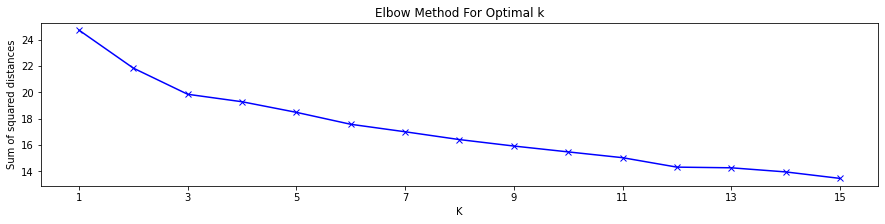

In [49]:
# plot each k and its error, i. e. sum of squared distanced of data points to their nearest cluster centroid.
plt.figure(figsize=(15,3))
plt.plot(Ks, sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.xticks(ticks = range(1, 16, 2))
plt.title('Elbow Method For Optimal k')

plt.savefig('data/opt_K_venues_clustering')
plt.show()

It seams that the point where the rate of decrease in the error shifts in at K=3. After that the shift in the error slows. 

In [50]:
k_opt = 3
kmc = KMeans(n_clusters=k_opt).fit(X)
kmc.labels_

array([0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmc.labels_)

merged = toronto_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
merged.drop(['Venue', 'Venue Latitude', 'Venue Longitude', 'Lat Lng'], axis = 1, inplace = True)

merged.head(3) # check the last columns!

Neighborhood  Neighborhood Latitude  \
0  Runnymede-Bloor West Village                43.6511   
1  Runnymede-Bloor West Village                43.6511   
2  Runnymede-Bloor West Village                43.6511   

   Neighborhood Longitude Venue Category  Cluster Labels  \
0              -79.476583       Tea Room               0   
1              -79.476583           Café               0   
2              -79.476583         Bakery               0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0           Coffee Shop                  Café                Bakery   
1           Coffee Shop                  Café                Bakery   
2           Coffee Shop                  Café                Bakery   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0                  Bank           Pizza Place                   Pub   
1                  Bank           Pizza Place                   Pub   
2                  Bank           Pizza Place                   Pub   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0     French Restaurant      Sushi Restaurant          Dessert Shop   
1     French Restaurant      Sushi Restaurant          Dessert Shop   
2     French Restaurant      Sushi Restaurant          Dessert Shop   

  10th Most Common Venue  
0     Italian Restaurant  
1     Italian Restaurant  
2     Italian Restaurant

Lets' vizualize the resulting clusters: 

In [52]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lng_toronto], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k_opt)
ys = [i + x + (i*x)**2 for i in range(k_opt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Neighborhood Latitude'], merged['Neighborhood Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save('data/venues_clusters.html')
map_clusters

Let's eaxamine the 3 clusters

In [53]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + list(range(5, merged.shape[1]))]][:3]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Runnymede-Bloor West Village           Coffee Shop                  Café   
1  Runnymede-Bloor West Village           Coffee Shop                  Café   
2  Runnymede-Bloor West Village           Coffee Shop                  Café   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Bakery                  Bank           Pizza Place   
1                Bakery                  Bank           Pizza Place   
2                Bakery                  Bank           Pizza Place   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                   Pub     French Restaurant      Sushi Restaurant   
1                   Pub     French Restaurant      Sushi Restaurant   
2                   Pub     French Restaurant      Sushi Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0          Dessert Shop     Italian Restaurant  
1          Dessert Shop     Italian Restaurant  
2          Dessert Shop     Italian Restaurant

In [62]:
cluster_most_common_venue = merged.loc[merged['Cluster Labels'] == 0]['1st Most Common Venue']
print("The first cluster contains %d neighborhoods." %(kmc.labels_[kmc.labels_ == 0].shape[0]))

share = 0
most_common_venues = ''
iteration = 0

while share <= 0.5:
    most_common_venues += "%ss, " %cluster_most_common_venue.value_counts().keys()[iteration]
    share += cluster_most_common_venue.value_counts()[iteration]/ cluster_most_common_venue.value_counts().values.sum()
    iteration += 1
    
most_common_venues.replace(", s", "")
print('The most common venues that account for %.2f of the 1st most common venues in the neighborhoods in the cluster \
is/are %s.' %(share*100, most_common_venues[:-2]))

The first cluster contains 110 neighborhoods.
The most common venues that accont for 51.18 of the 1st most common venues in the neighborhoods in the cluster is/are Coffee Shops, Cafés, Italian Restaurants.


In [55]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + list(range(5, merged.shape[1]))]][:3]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
2618      Malvern                  Pool         Women's Store   
2679    West Hill                  Pool         Women's Store   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
2618   Egyptian Restaurant              Dive Bar       Doctor's Office   
2679   Egyptian Restaurant              Dive Bar       Doctor's Office   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2618               Dog Run            Donut Shop           Dry Cleaner   
2679               Dog Run            Donut Shop           Dry Cleaner   

     9th Most Common Venue       10th Most Common Venue  
2618   Dumpling Restaurant  Eastern European Restaurant  
2679   Dumpling Restaurant  Eastern European Restaurant

In [56]:
cluster_most_common_venue = merged.loc[merged['Cluster Labels'] == 1]['1st Most Common Venue']
print("The second cluster contains %d neighborhoods." %(kmc.labels_[kmc.labels_ == 1].shape[0]))

share = 0
most_common_venues = ''
iteration = 0

while share <= 0.5:
    most_common_venues += "%ss, " %cluster_most_common_venue.value_counts().keys()[iteration]
    share += cluster_most_common_venue.value_counts()[iteration]/ cluster_most_common_venue.value_counts().values.sum()
    iteration += 1

print('The most common venues that account for %.2f of the 1st most common venues in the neighborhoods in the cluster \
is/are %s.' %(share*100, most_common_venues[:-2]))

The second cluster contains 2 neighborhoods.
The most common venues that accont for 100.00 of the 1st most common venues in the neighborhoods in the cluster is/are Pools.


In [59]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + list(range(5, merged.shape[1]))]][:3]

Neighborhood 1st Most Common Venue  \
545  Cabbagetown-South St. James Town                  Park   
546  Cabbagetown-South St. James Town                  Park   
547  Cabbagetown-South St. James Town                  Park   

    2nd Most Common Venue 3rd Most Common Venue  4th Most Common Venue  \
545       Thai Restaurant                  Farm  General Entertainment   
546       Thai Restaurant                  Farm  General Entertainment   
547       Thai Restaurant                  Farm  General Entertainment   

    5th Most Common Venue 6th Most Common Venue        7th Most Common Venue  \
545              Building           Snack Place  Eastern European Restaurant   
546              Building           Snack Place  Eastern European Restaurant   
547              Building           Snack Place  Eastern European Restaurant   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
545       Doctor's Office               Dog Run             Donut Shop  
546       Doctor's Office               Dog Run             Donut Shop  
547       Doctor's Office               Dog Run             Donut Shop

In [58]:
cluster_most_common_venue = merged.loc[merged['Cluster Labels'] == 2]['1st Most Common Venue']
print("The third cluster contains %d neighborhoods." %(kmc.labels_[kmc.labels_ == 2].shape[0]))

share = 0
most_common_venues = ''
iteration = 0

while share <= 0.5:
    most_common_venues += "%ss, " %cluster_most_common_venue.value_counts().keys()[iteration]
    share += cluster_most_common_venue.value_counts()[iteration]/ cluster_most_common_venue.value_counts().values.sum()
    iteration += 1

print('The most common venues that account for %.2f of the 1st most common venues in the neighborhoods in the cluster \
is/are %s.' %(share*100, most_common_venues[:-2]))

The third cluster contains 28 neighborhoods.
The most common venues that accont for 51.59 of the 1st most common venues in the neighborhoods in the cluster is/are Parks.
